# Uncertainty in aging trajectories

Andrew Weng

Nov 21, 2022

In [1]:
from src import plotter as plotter
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.interpolate import interp1d
import numpy as np
import warnings; warnings.filterwarnings('ignore')

plotter.initialize(plt)

In [2]:
time_y = np.array([0, 4, 8])
soh_p_set = [np.array([100, 85, 70]),   # linear
             np.array([100, 80, 70]),   # self-limiting
             np.array([100, 90, 70])]   # accelerating

soh_err_std_1_p = 1
soh_err_std_2_p = 2

In [3]:
def fit_func(x, A, n, b):
    return A * x ** n + b

Running simulations for set 0...
Running simulations for set 1...
Running simulations for set 2...


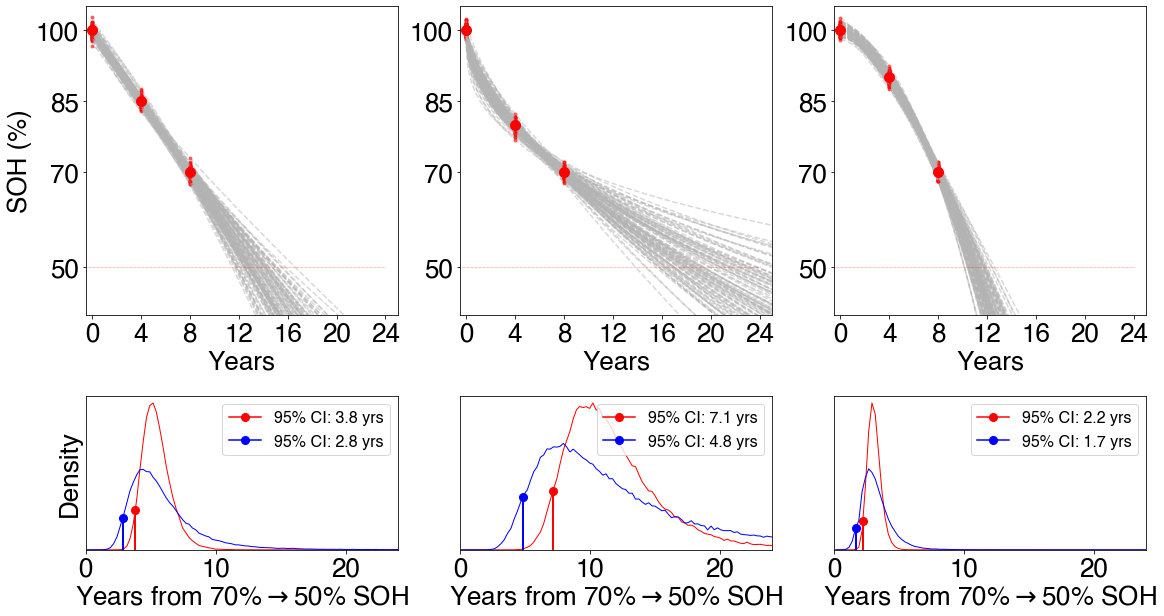

In [4]:
NCOLS = 3
NROWS = 2

gridspec = dict(hspace=0.35, wspace=0.2, 
                height_ratios=[2,1], 
                width_ratios=[1,1,1])

fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS,
                        gridspec_kw=gridspec,
                        figsize=(19,10))

for icol, soh_p in zip(range(NCOLS), soh_p_set):

    N_TRIALS = 100000

    y_rul_1 = [] 
    y_rul_2 = [] 

    print(f'Running simulations for set {icol}...')

    for itrial in range(N_TRIALS):
        
        y_meas_1 = np.random.normal(soh_p, soh_err_std_1_p)
        y_meas_2 = np.random.normal(soh_p, soh_err_std_2_p)
        
        try: 
            popt1, pcov1 = curve_fit(fit_func, time_y, y_meas_1)
            popt2, pcov2 = curve_fit(fit_func, time_y, y_meas_2)
        except:
            continue

        x_modl = np.linspace(0, 30, 1000)
        y_modl_1 = fit_func(x_modl, *popt1)

        time_to_50_pct_1 = ( (50 - popt1[2]) / popt1[0] ) ** (1/popt1[1]) - 8
        time_to_50_pct_2 = ( (50 - popt2[2]) / popt2[0] ) ** (1/popt2[1]) - 8

        if not np.isnan(time_to_50_pct_1) and not np.isinf(time_to_50_pct_1):
            y_rul_1.append(time_to_50_pct_1) # remaining useful life is defined as time to 50%
                
            if itrial < 100:
                axs[0, icol].plot(x_modl, y_modl_1, ls='--', c=[0.7, 0.7, 0.7], alpha=0.5)
                axs[0, icol].plot(time_y, y_meas_1, ls='', c='r', alpha=0.5, ms=3, marker='o')

        if not np.isnan(time_to_50_pct_2) and not np.isinf(time_to_50_pct_2):
            y_rul_2.append(time_to_50_pct_2) # remaining useful life is defined as time to 50%


    axs[0, icol].plot(time_y, soh_p, marker='o', ls='', ms=10, c='r')
    axs[0, icol].set_xlim((-0.5, 25))
    axs[0, icol].set_ylim((40, 105))
    axs[0, icol].grid(False)
    axs[0, icol].hlines(y=50, xmin=-0.5, xmax=24, linewidth=0.5, color='r', ls=':')
 
    axs[0, icol].set_xlabel('Years')
    axs[0, icol].set_xticks([0, 4, 8, 12, 16, 20, 24])
    axs[0, icol].set_yticks([50, 70, 85, 100])

    # Calculate histogram of years from 70% to 50% SOH
    hist1, binedges1 = np.histogram(y_rul_1, np.linspace(0, 25, 100), density=True)
    bincenters1 = np.mean(np.vstack([binedges1[0:-1],binedges1[1:]]), axis=0)

    hist2, binedges2 = np.histogram(y_rul_2, np.linspace(0, 25, 100), density=True)
    bincenters2 = np.mean(np.vstack([binedges2[0:-1],binedges2[1:]]), axis=0)

    # Calculate minimum years within some confidence interval
    # e.g. (95% confident that the years will exceed some value)
    cdf = np.cumsum(hist1) / np.sum(hist1)
    f_interp_11 = interp1d(cdf, bincenters1)
    f_interp_12 = interp1d(bincenters1, hist1)
    confint = 0.95
    years_conf_1 = f_interp_11(1 - confint)

    cdf = np.cumsum(hist2) / np.sum(hist2)
    f_interp_21 = interp1d(cdf, bincenters2)
    f_interp_22 = interp1d(bincenters2, hist2)
    confint = 0.95
    years_conf_2 = f_interp_21(1 - confint)

    # Nominal years
    years_nom = bincenters2[np.argmax(hist2)]
    hist_nom  = np.max(hist2)

    axs[1, icol].plot(years_conf_1, f_interp_12(years_conf_1), 'r', 
    marker='o', ms=8, label=f'95% CI: {years_conf_1:.1f} yrs')
    axs[1, icol].vlines(x=years_conf_1, ymin=0, ymax=f_interp_12(years_conf_1), lw=2, color='r')
    axs[1, icol].plot(bincenters1, hist1, color='r', lw=1)

    axs[1, icol].plot(years_conf_2, f_interp_22(years_conf_2), 'b', 
    marker='o', ms=8, label=f'95% CI: {years_conf_2:.1f} yrs')
    axs[1, icol].vlines(x=years_conf_2, ymin=0, ymax=f_interp_22(years_conf_2), lw=2, color='b')
    axs[1, icol].plot(bincenters2, hist2, color='b', lw=1)

    axs[1, icol].grid(False)
    axs[1, icol].legend(fontsize=16)
    axs[1, icol].set_xlabel(r'Years from 70%$\rightarrow$50% SOH')
    axs[1, icol].set_yticks([])
    axs[1, icol].set_xlim((0,24))
    axs[1, icol].set_ylim(bottom=0)

axs[0, 0].set_ylabel('SOH (%)')
axs[1, 0].set_ylabel('Density')

fig.savefig('outputs/fig_aging_trajectory.png', dpi=300)